<a href="https://colab.research.google.com/github/MaggieLieu/MLiS2/blob/master/workshops/workshop3/CNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise we will train a convolutional neural network to classify MNIST characters. 

First we make sure we have GPU. Go to Edit $\rightarrow$ Notebook Settings $\rightarrow$ Hardware Accelerator $\rightarrow$ GPU. 

You may have to restart the Runtime. Go to Runtime $\rightarrow$ Restart runtime.

Now we need to maksure we are using tensorflow v2 and not 1. You will need to restart the runtime again. 

In [175]:
# get packages
#%matplotlib inline
import matplotlib.pyplot as plt 
#%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

Okay lets download a dataset. In the tensorflow_datasets package we have access to many well known machine learning datasets. See  
https://www.tensorflow.org/datasets/catalog/overview  
for the full list. Here we will download the MNIST dataset which contains images of handwritten numbers 0-9. 

In [176]:
ds = tfds.load(name="mnist", as_supervised = True) #get mnist dataset 
train, test = ds["train"], ds["test"] #split train test 

The data are already in test and train sets and we can see how much data is in each. We won't necessarily use all of this data later.

In [177]:
ntrain = len([image[0] for image in train])
ntest = len([image[0] for image in test])

print('Train sample: ', ntrain)
print('Test sample: ', ntest)

2025-02-17 15:22:47.529497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train sample:  60000
Test sample:  10000


2025-02-17 15:22:48.093822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's take the first image from the train dataset and visualise it. 

image 1 shape:  (28, 28, 1)


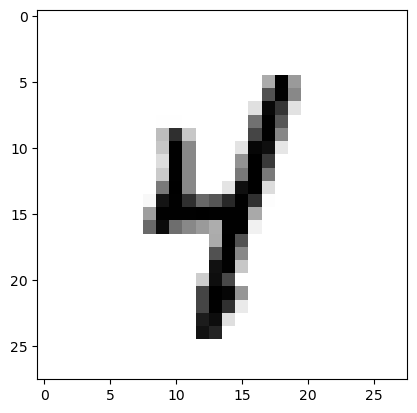

In [178]:
# take 1 image from train and convert to float64 and values 0-1
data1 = train.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).take(1)

#get first image data and label and plot it
features, labels = iter(data1).next()
print('image 1 shape: ', np.shape(features))
plt.imshow(features[:,:,0], cmap='gray_r')
plt.show()

You should see that we have an 28x28 grayscale image (1 channel) of the handwritten digit 8. 

To give you a feel for what the convolutional layer does, we are now going to apply filters to this image. 

Firstly we will apply a horizontal filter  
\begin{bmatrix}
1 & 1 & 1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix}

This filter enhances the horizontal features of the image. 

image shape:  (1, 26, 26, 1)


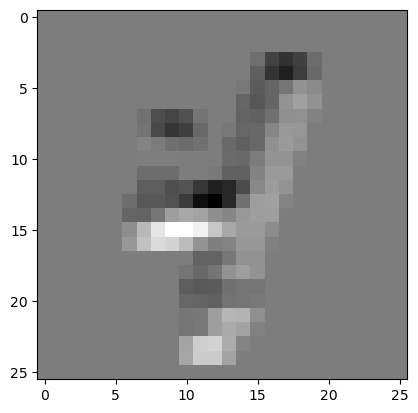

In [179]:
hor_filter = [[1,1,1],[0,0,0],[-1,-1,-1]]

#2D convolution 
output = tf.nn.conv2d(
      input=np.reshape(features, [1,28,28,1]), #batch, height, width, depth
      filters=np.reshape(hor_filter, [3,3,1,1]), #height, width, in_channels, out_channels
      strides=[1,1,1,1], 
      padding="VALID")
print('image shape: ', np.shape(output))
plt.imshow(output[0,:,:,0], cmap='gray')
plt.show()

The filter has extracted the features of horizontal edges in the image. Note that the image size has shrunk from 28x28 to 26x26. 

Now lets try a vertical filter  
\begin{bmatrix}
1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1
\end{bmatrix}

You should find that this filter extracts the vertical edges of the image. Try it yourself:

image shape:  (1, 26, 26, 1)


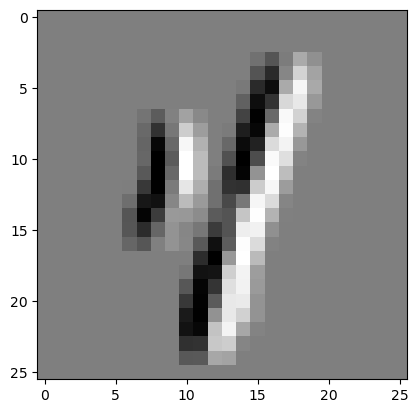

In [ ]:
ver_filter = [[1,0,-1],[1,0,-1],[1,0,-1]] #fill this in with the values of the vertical filter above

output = tf.nn.conv2d( #Look to the previous code chunk with the vertical filter to fill in this function
      input=np.reshape(features, [1,28,28,1]), 
      filters=np.reshape(ver_filter, [3,3,1,1]),
      strides=[1,1,1,1], 
      padding="VALID")
print('image shape: ', np.shape(output));
plt.imshow(output[0,:,:,0], cmap='gray');
plt.show()

# Convolutional layer
Now your task is to write your own function that takes an image, and a kernel to perform the convolution operation. Assume stride 1 and no padding.

First do it with just one kernel and 1 channel

In [181]:
# It will first help to write a function that unrolls the kernel like shown in the course notes and lecture.
# It should take a kernel matrix F of size [ky,kx] and return a matrix of size [ox*oy,nx*ny ] where nx,ny 
# is the dimension of the input after padding (in_pad) and ox, oy are the output dimensions.
# Note that there are many variations to writing a convolution function, so feel free to just code your way 
# and ignore pointers if you wish
 
def unroll(F, ky, kx, ny, nx, oy, ox, stride):
    #calculate the output size of the unrolled matrix
    ux = ox*oy
    uy = nx*ny
    
    #pad the filter first using the function tf.pad so that its the same size as the image
    Fpadded = tf.pad(F, [[0, (nx-kx)],[0, (ny-ky)]] )

    #flatten the filter into a vector of size uy
    Fflat = tf.reshape(Fpadded,[uy])
    
    #unroll the filter
    unrolledF = []
    for iy in range(oy):
        for ix in range(ox):
            unrolled = tf.roll(Fflat, shift=(ix*stride+iy*(stride*nx)), axis=0) #shifts the flattened filters for each row of the unrolled filter
            unrolledF.append(unrolled)
    out = tf.stack(unrolledF)

    out = tf.reshape(out, [ux,uy])    #reshape to output size
    return(out)


# The convolutional layer should take an image of size [iy,ix], filter kernel of size [kx,ky], 
#bias of size [1], padding of size [1] and stride of size 1 

def convolve2d(infeat, kernel, bias, padding, stride):
    # get the shape of the kernel and input using the function get_shape()
    ky, kx = kernel.get_shape()
    iy, ix = infeat.get_shape()
    print(f'ky: {ky}, kx: {kx}, iy: {iy}, ix: {ix}')
    
    #add padding to the input and get the shape of the result
    in_pad = tf.pad(infeat, [[padding,padding],[padding,padding]])
    ny, nx = in_pad.get_shape()
    print(f'ny: {ny}, nx: {nx}, \nin_pad: \n{in_pad}')
    
    # Calculate the output size - using [Input-Kernel+2*Padding/Stride]+1
    ox = int(((nx - kx)/stride) + 1)
    oy = int(((ny - ky)/stride) + 1)
    print(f'ox: {ox}, oy: {oy}')    
    
    #unroll the kernel 
    unrollF = unroll(kernel, ky, kx, ny, nx,oy,ox, stride=stride)
    #flatten the input
    unrollI = np.reshape(in_pad, [nx*ny])

    #multiply the unrolled matrices together
    convO = tf.tensordot(unrollF, unrollI, axes=1) 
    
    #reshape to outout size and add bias term
    conv_reshaped = tf.reshape(convO, [ox,oy]) 
    outfeat = conv_reshaped + bias

    return outfeat

To check you have succeeded, we'll apply it to a test, if the printed difference is 0, you can move forward

In [182]:
f1 = [[2,1],[2,1]]
a = tf.constant([[1,2,3],[1,2,3],[1,2,3]], dtype=tf.float64)
out = convolve2d(a, tf.constant(f1, dtype=tf.float64), bias=0, padding=1, stride=1)
dif = [[ 1.,  4.,  7.,  6.],[ 2.,  8., 14., 12.],[ 2.,  8., 14., 12.], [ 1.,  4.,  7.,  6.]]
print('\nDifference from truth: '); tf.print(tf.reduce_sum(dif-out))

ky: 2, kx: 2, iy: 3, ix: 3
ny: 5, nx: 5, 
in_pad: 
[[0. 0. 0. 0. 0.]
 [0. 1. 2. 3. 0.]
 [0. 1. 2. 3. 0.]
 [0. 1. 2. 3. 0.]
 [0. 0. 0. 0. 0.]]
ox: 4, oy: 4

Difference from truth: 
0


Now we want to generalise to 3 channels. Remember the number of channels in the image must equal the number of channels in the kernel. 

In [183]:
# The output of the unrolled kernel should be still be 2D
def unroll(F, ky, kx, kz, ny, nx, nz, oy, ox, stride):
    uy = ox*oy     #output size
    ux = nx*ny*nz  #input size

    #pad and flatten the filter
    Fpadded = tf.pad(F, [[0, (nx-kx)],[0, (ny-ky)],[0, (nz-kz)]] )  # now the filter has width, height and depth, so think carefully about what padding needs to be applied
    Fflat = tf.reshape(Fpadded, [nx*ny*nz])  # dimensions should be the [nx*ny*nz]

    #unroll the filter
    unrolledF = []
    for iy in range(oy):
        for ix in range(ox):
            unroll = tf.roll(Fflat, shift=(ix*(stride*nz)+iy*(stride*nx*nz)), axis=0)   #apply the tf.roll function to get the rolled filter, think carefully about how the depth dimension should be incorporated in to the shift
            unrolledF.append(unroll)
    
    #stack and unroll the matrices, remember from the lectures what should the output size of the 3 channel image be? 
    out = tf.stack(unrolledF)
    print(out)
    out = tf.reshape(out, [uy,ux])

    return(out)


#here beware that although we have multi channels, the bias remains as 1 per filter, not per filter channel
def convolve2d(infeat, kernel, bias, padding, stride):
  #define sizes of kernel and input
    ky, kx, kz = kernel.get_shape()
    iy, ix, iz = infeat.get_shape()
    
    #pad input and get new dimensions
    in_pad = tf.pad(infeat, [[padding,padding],[padding,padding],[0,0]])
    ny, nx, nz = in_pad.get_shape()

    
    # calculate the outputsize
    ox = int(((nx-kx)/stride) + 1)
    oy = int(((ny-ky)/stride) + 1)
    
    
    #unroll the matrix and input
    unrollI = tf.reshape(in_pad, [nx*ny*nz])
    unrollF = unroll(kernel,ky, kx, kz, ny, nx,nz,oy,ox, stride=stride)
    
    #multiply the 2 matrices together
    convO = tf.tensordot(unrollF, unrollI, axes=1)

    conv_reshaped = tf.reshape(convO, [oy,ox]) #reshape

    outfeat = conv_reshaped + bias     #add the bias term

    return outfeat

Lets check you're correct with an example

In [184]:
# 3 channel input
a = tf.constant([[[5,2,3],[1,2,1],[1,2,3],[1,2,3]],
                 [[3,2,3],[1,0,3],[1,2,1],[0,0,1]],
                 [[1,1,1],[1,2,3],[0,2,3],[1,2,1]],
                 [[1,0,3],[0,2,0],[1,2,3],[1,2,3]]], dtype=tf.float64)

# 3 channel kernel
f1 = [[2,1],[2,1]]
f2 = [[3,1],[3,3]]
f3 = [[3,2],[2,3]]
f=np.dstack((f1,f2,f3))

out = convolve2d(a, tf.constant(f, dtype=tf.float64), 0, 1, 1)
dif =[[20., 32., 26., 30., 14.],[31., 58., 38., 39., 19.],[18., 51., 45., 35., 13.],[14., 31., 47., 50., 25.], [ 7., 13., 15., 26., 17.]]
print('Difference from truth: '); tf.print(tf.reduce_sum(dif-out))

tf.Tensor(
[[2. 3. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 3. 3.]], shape=(25, 108), dtype=float64)
Difference from truth: 
0


Now lets generalise to multiple multichannel-filters where kn corresponds to each of the filters

In [185]:
#The output of the unrolled matrix should be [kn,uy,ux]
def unroll(F,  kn, ky, kx, kz, ny, nx, nz, oy, ox, stride):
    #define output size of unrolled matrix
    uy = ox*oy
    ux = nx*ny*nz

    #pad and flatten the filter. The padded filter should have dimensions [filters, height, width, depth] 
    Fpadded = tf.pad(F, [[0,0],[0, (ny-ky)],[0, (nx-kx)],[0,0]])
    Fflat = tf.reshape(Fpadded, [kn, nx*ny*nz]) #dimensions should be the [kn, nx*ny*nz]

    #unroll the matrix
    unrolledF = [] 
    for iy in range(oy):
        for ix in range(ox):
            unroll = tf.roll(Fflat, shift=(ix*(stride*nz)+iy*(stride*nx*nz)), axis=1) #since we have added multifilters the axis of roll will have changed, but the shift will be the same as the previous code chunk
            unrolledF.append(unroll)

    #stack again beware of the axis you want to stack
    out = tf.stack(unrolledF, axis=1)

    #reshape to size [kn,uy,ux]
    out = tf.reshape(out, [kn,uy,ux])

    return(out)


def convolve2d(infeat, kernel, bias, padding, stride):
    kn, ky, kx, kz = kernel.get_shape()
    iy, ix, iz = infeat.get_shape()
    
    #pad input and get size
    in_pad = tf.pad(infeat, [[padding,padding],[padding,padding],[0,0]])
    ny, nx, nz = in_pad.get_shape()

    #calculate outputsize 
    ox = int(((nx-kx)/stride) + 1)
    oy = int(((ny-ky)/stride) + 1)
    
    #unroll input to size ny*nx*nz
    unrollI = tf.reshape(in_pad, [ny*nx*nz])
    #unroll kernel
    unrollF = unroll(kernel, kn, ky, kx, kz, ny, nx,nz,oy,ox, stride=stride)

    #multiply the unrolled matrices and dont forget to add the bias

    convO = tf.tensordot(unrollF, unrollI, axes=1) #convolution
    conv_reshaped = tf.reshape(tf.transpose(convO), [oy,ox,kn]) #reshape

    outfeat = conv_reshaped + bias

    return outfeat

Check it works, the output of the next chunk should be 0

In [186]:
# 4x3 channel kernels
f1 = [[2,1],[2,1]]
f2 = [[3,1],[3,3]]
f3 = [[3,2],[2,3]]
k1 = np.dstack((f1,f1,f1))
k2 = np.dstack((f2,f2,f2))
k3 = np.dstack((f3,f3,f3))
k4 = np.dstack((f1,f2,f3))

out = convolve2d(a, tf.constant([k1,k2,k3,k4], dtype=tf.float64), 0, 1, 1)

dif =[[[10., 30., 30., 20.],
        [24., 42., 32., 32.],
        [14., 30., 26., 26.],
        [18., 36., 30., 30.],
        [12., 18., 12., 14.]],

       [[18., 34., 44., 31.],
        [44., 70., 66., 58.],
        [26., 42., 44., 38.],
        [27., 39., 41., 39.],
        [14., 21., 20., 19.]],

       [[11., 17., 25., 18.],
        [32., 55., 56., 51.],
        [29., 49., 47., 45.],
        [23., 40., 36., 35.],
        [10., 15., 11., 13.]],

       [[ 7., 15., 18., 14.],
        [22., 33., 35., 31.],
        [27., 47., 50., 47.],
        [32., 55., 53., 50.],
        [20., 30., 24., 25.]],

       [[ 4.,  4.,  8.,  7.],
        [10., 14., 16., 13.],
        [10., 12., 18., 15.],
        [18., 24., 30., 26.],
        [12., 18., 18., 17.]]]

print('Difference from truth: '); tf.print(tf.reduce_sum(dif-out))


Difference from truth: 
0


Now lets allow for batches of images

In [187]:
def unroll(F,  kn, ky, kx, kz, nn, ny, nx, nz, oy, ox, stride):
    uy = ox*oy
    ux = nx*ny*nz

    #pad and flatten the filter
    Fpadded = tf.pad(F, [[0,0],[0, (ny-ky)],[0, (nx-kx)],[0,0]])
    Fflat = tf.reshape(Fpadded,[kn, nz*ny*nx])
    unrolledF = [] 
    for iy in range(oy):
        for ix in range(ox):
            unroll = tf.roll(Fflat, shift=(ix*(stride*nz)+iy*(stride*nx*nz)), axis=1)
            unrolledF.append(unroll)
    out=tf.stack(unrolledF, axis=1)
    out=tf.reshape(out, [kn, uy,ux])

    return(out)

def convolve2d(infeat, kernel, bias, padding, stride):
    kn, ky, kx, kz = kernel.get_shape()
    inn,iy, ix, iz = infeat.get_shape()
    
    #pad input, now we have 4 dimensions [batch, width, height, depth] - what dimensions need padding?
    in_pad = tf.pad(infeat, [[0,0],[padding,padding],[padding,padding],[0,0]])
    #get new shape
    nn, ny, nx,nz = in_pad.get_shape()
    
    ox = (nx - kx) // stride + 1 # output size
    oy = (ny - ky) // stride + 1 
    
    #reshape padded input to size of [batches, width*height*depth]
    unrollI = tf.reshape(in_pad, [nn, nx*ny*nz])
    unrollF = unroll(kernel, kn, ky, kx, kz, nn, ny, nx,nz,oy,ox, stride=stride)

    convO = tf.tensordot(unrollF, unrollI, axes=[[2],[1]]) #convolution
    conv_reshaped = tf.reshape(tf.transpose(convO), [nn,oy,ox,kn]) #reshape
    outfeat = conv_reshaped + bias

    return outfeat

Check your functions work by applying the convolution layer with the vertical filter on the first image on MNIST. 

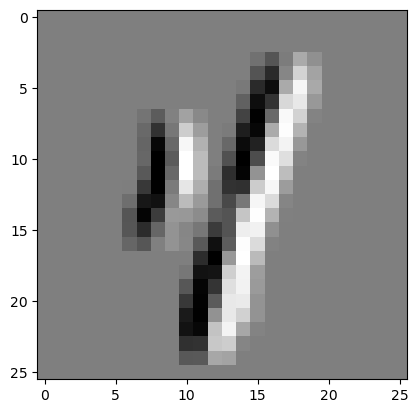

In [188]:
x = tf.constant(np.reshape(features[:,:,0],(1,28,28,1)))
b = tf.constant(np.reshape(ver_filter, (1,3,3,1)), dtype=tf.float64)
np.shape(b)
out=convolve2d(x,b,0, padding=0, stride=1);
out.get_shape()
plt.imshow(out[0,:,:,0], cmap='gray');

Compare the convolution with the correct answer

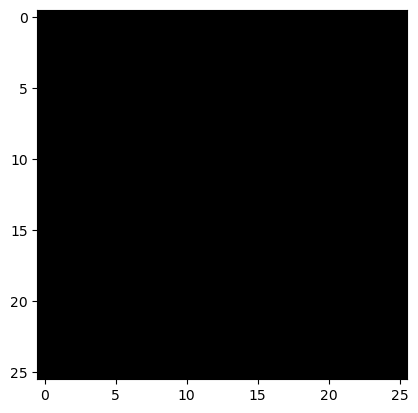

In [189]:
difs = out[0,:,:,0] - output[0,:,:,0]
plt.imshow(difs, cmap='gray')
plt.show()

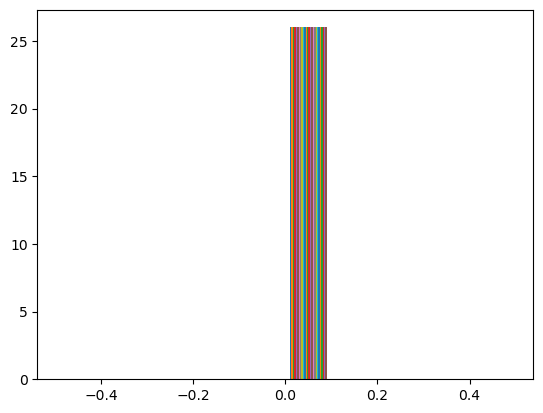

In [190]:
plt.hist(difs);

You might see some differences but these are due to rounding errors

# Activation Function

The convolution operation is linear. To make it non-linear we need to add an activation function. Here your task is to write a ReLU activation function

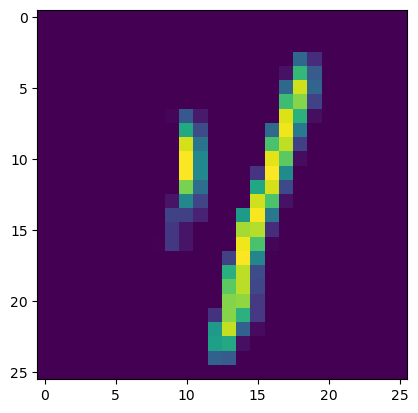

In [191]:
def ReLU(infeat):
    return tf.maximum(infeat, tf.zeros_like(infeat))
    
relu0 = ReLU(out)

plt.imshow(relu0[0,:,:,0])

Compare it to the built in function it should look like:

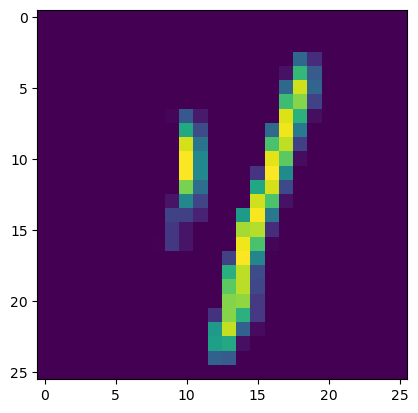

In [192]:
true_relu0 = tf.nn.relu(out)
plt.imshow(true_relu0[0,:,:,0]);

# Pooling layer 
Write a function to do pooling

In [193]:
def pooling(infeat, ky, kx,kz, padding, stride, pooling_type):
    
    #pad the input, again remember there are 4 dimensions - think which ones need padding
    in_pad = tf.pad(infeat, [[0,0],[padding,padding],[padding,padding],[0,0]])
    
    #get new shape of input
    nn, ny, nx, nz = infeat.get_shape()
    kn = nn
    
    #get output shapes
    ox = (nx - kx) // stride + 1 # output size
    oy = (ny - ky) // stride + 1 
    oz = nz
    
    #unroll to get indices to pool
    unrolledF = unroll(tf.ones([kn,ky,kx,kz]), kn, ky, kx, kz, nn, ny, nx, nz, oy, ox, stride)

    #multiply unrolled kernel with input to get values to pool
    flatin = tf.reshape(in_pad,[nn,nz*nx*ny])
    tilein = tf.tile(flatin, [1,ox*oy])
    test = tf.reshape(tilein, [nn, ox*oy, nz*nx*ny])
    pools = tf.boolean_mask(test, unrolledF[:,:,:])
    tileout = tf.reshape(pools, [nn,ox*oy,kx*ky,oz])
    
    #apply max or mean pooling using tf.reduce_max and tf.reduce_mean on axis 2
    if(pooling_type=='MAX'):
        out = tf.reduce_max(tileout, axis=2)
    elif(pooling_type=='AVG'):
        out = tf.reduce_mean(tileout, axis=2)
    return tf.reshape(out, [nn,oy,ox,oz])

Apply the pooling layer to the raw image with a 5x5 filter

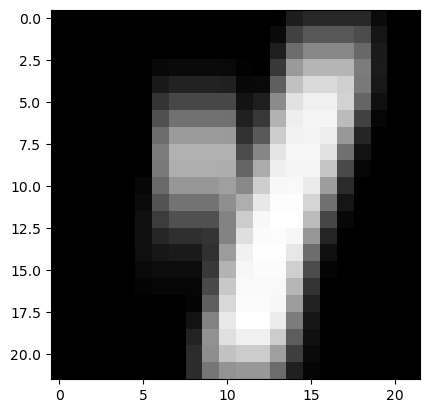

In [194]:
pooled = pooling(relu0,5,5,1,0,1, 'AVG')
plt.imshow(pooled[0,:,:,0], cmap='gray');

You should have got something like this:

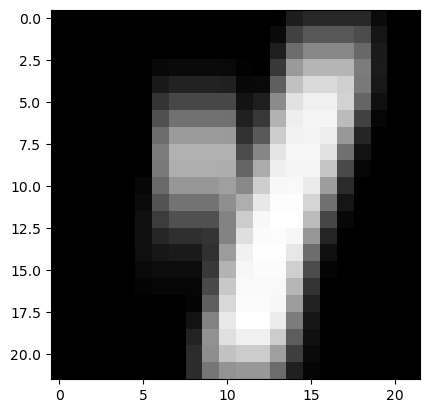

In [195]:
n, y,x,z = np.shape(relu0)
true_pooled = tf.nn.pool(
    input = np.reshape(relu0, [1,y,x,1]),
    window_shape = [5,5],
    strides=[1,1],
    pooling_type = 'AVG',
    padding = 'VALID'
)
plt.imshow(true_pooled[0,:,:,0],cmap='gray');

How does Max pool and average pool compare?


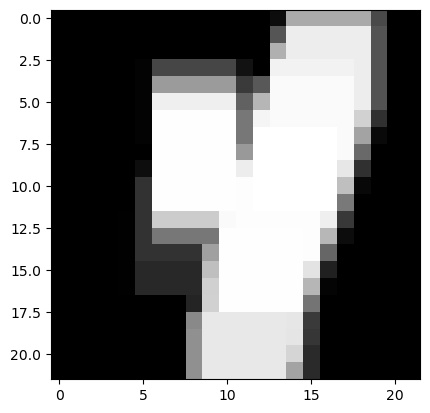

In [196]:
pooled = pooling(relu0,5,5,1,0,1, 'MAX')
plt.imshow(pooled[0,:,:,0], cmap='gray');

What happens when you apply the activation? 

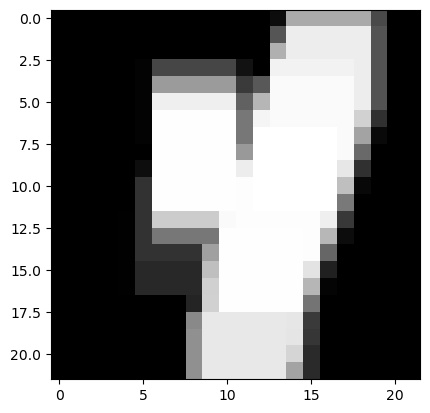

In [197]:
relu1 = ReLU(pooled)
plt.imshow(relu1[0,:,:,0], cmap='gray')

# Fully connected layer

The fully connected layer, is a layer that has no shared weights. In this part you need to write a function for the fully connected layer. Remember here there is a bias for every filter

In [198]:
def fully_connected(infeat, kernel, bias):
    #get input and kernel shapes
    nn, ny, nx, nz = infeat.get_shape()
    kn, ky, kx, kz = kernel.get_shape()

    #reshape input and kernel to shape, they should both be 2D matrices
    flatin = tf.reshape(infeat, [nn, ny*nx*nz])
    flatk = tf.reshape(kernel, [kn, ky*kx*kz])

    # apply matrix multiplication and bias. You may need to use tf.transpose to get the right shape. output size should be [nn,1,1,kn]
    #print(f'flatin: \n{flatin}\nflatk: \n{flatk}')
    out = tf.reshape(tf.transpose(tf.tensordot(flatk, flatin, axes=[1,1])) + bias, [nn,1,1,kn])
    return out

Now test the fully connected layer works 

In [199]:
kn = 2
imn = 1
k = np.random.randint(low=0, high=2,size=[kn,3,3,1])

b = tf.zeros([imn,kn],dtype=tf.float64)

im = np.random.randint(low=0, high=5,size=[imn,3,3,1])
fully_connected(tf.constant(im,dtype=tf.float64),tf.constant(k,dtype=tf.float64), b )

<tf.Tensor: shape=(1, 1, 1, 2), dtype=float64, numpy=array([[[[13., 14.]]]])>

Actually you should find that the fully connected layer is the same as the conv2D layer using a kernel size the same as the input size

In [200]:
convolve2d(tf.constant(im,dtype=tf.float64),tf.constant(k,dtype=tf.float64),0, padding=0, stride=1)

<tf.Tensor: shape=(1, 1, 1, 2), dtype=float64, numpy=array([[[[13., 14.]]]])>

apply the fully connected layer we just created to the output of the ReLU activation

In [201]:
nn,ny,nx,nz = relu1.get_shape()
outsz = 2

#kernel size has dimensions [input width, input height,output size]
ink = tf.random.normal([outsz, ny, nx, nz], dtype=tf.float64)

#bias size has dimensions [output size]
inb = tf.zeros([nn,outsz],dtype=tf.float64)

outim = fully_connected(relu1, ink, inb)
tf.print(outim);

[[[[-66.845825750670485 11.700667863765851]]]]


after a fully connected layer you must add non-linearity via an activation function. Since its not yet the last layer we can add ReLU activation

In [202]:
relu2 = ReLU(outim)
tf.print(relu2)

[[[[0 11.700667863765851]]]]


# Softmax activation

For the last layer, you probably want to use softmax activation. So here you should write a function to do softmax

In [203]:
def softmax(infeat):
    innorm = infeat - tf.reduce_max(infeat) #normalise the input values with the maximum to prevent blow up
    inexp = tf.exp(innorm) 
    tot = tf.reduce_sum(inexp) #normalisation factor
    #print(f'infeat: \n{infeat}\ninnorm: \n{innorm}\ninexp: \n{inexp}\ntot: \n{tot}')
    return inexp / tot

Add the final fully connected layer and softmax activation

In [204]:
nn,ny,nx,nz= relu2.get_shape()
outsz = 3

#kernel size has dimensions [output size, input width, input height]
ink = tf.random.normal([outsz,ny,nx,nz], dtype=tf.float64)

#bias size has dimensions [output size, 1]
inb = tf.zeros([nn,outsz],dtype=tf.float64)

outim = fully_connected(relu2, ink, inb)
out = softmax(outim)
print(f'out: \n{out}')

out: 
[[[[9.99900681e-01 9.69226017e-05 2.39624706e-06]]]]


define a loss function


In [205]:
def cross_entropy_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, tf.shape(y_pred))
    return tf.reduce_mean(tf.losses.categorical_crossentropy( y_true,  y_pred))

# Build the neural network

Now you have all the functions you need to build your neural network so first you need to set up all the variables and their dimensions. We are going to make a 4 layer network with CONV-RELU-MAXPOOL-CONV-RELU-MAXPOOL-FC-FC

In [206]:
# First initialise variables 
f1n, f1y, f1x, f1z = 10, 3, 3, 1
W1 = tf.Variable(tf.random.normal([f1n, f1y, f1x, f1z], stddev=0.01, dtype=tf.float64 ), name='W1')
b1 = tf.Variable(tf.zeros([f1n], dtype=tf.float64 ), name='b1')

f2n, f2y, f2x, f2z = 10, 3, 3, 10
W2 = tf.Variable(tf.random.normal([f2n, f2y, f2x, f2z], stddev=0.01, dtype=tf.float64 ), name='W2')
b2 = tf.Variable(tf.zeros([f2n], dtype=tf.float64 ), name='b2')

f3n, f3y, f3x, f3z = 50, 20, 20, 10
W3 = tf.Variable(tf.random.normal([f3n, f3y, f3x, f3z], stddev=0.01, dtype=tf.float64 ), name='W3')
b3 = tf.Variable(tf.zeros([f3n], dtype=tf.float64 ), name='b3')

f4n, f4y, f4x, f4z = 10, 1, 1, 50
W4 = tf.Variable(tf.random.normal([f4n, f4y, f4x, f4z], stddev=0.01, dtype=tf.float64 ), name='W4')
b4 = tf.Variable(tf.zeros([f4n], dtype=tf.float64 ), name='b4')

Next set up the model

In [207]:
def model( X ) :
    X = tf.cast( X , dtype=tf.float64 )
    
    #LAYER 1
    conv1 = convolve2d(X, W1, b1, padding=0, stride=1);
    conv1act = ReLU(conv1)
    pool1 = pooling(conv1act, 3, 3, 10, 0, 1, 'MAX') #out[24,24,10]
    
    #LAYER 2
    conv2 =  convolve2d(pool1, W2, b2, padding=0, stride=1);
    conv2act = ReLU(conv2) 
    pool2 = pooling(conv2act, 3, 3,10, 0, 1, 'MAX') #out[20,20,10]

    #LAYER 3
    fc1 = fully_connected(pool2, W3, b3)
    fc1act = ReLU(fc1) #out[1,1,50]

    #LAYER 4
    fc2 = fully_connected(fc1act, W4, b4)
    fc2act = softmax(fc2) #out[1,1,10]
    
    return(fc2act)

Train the model on MNIST training set

In [208]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

def train_step( model, X , Y ):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy_loss( model( X ), Y)
    grads = tape.gradient( current_loss , [W1,b1,W2,b2,W3,b3,W4,b4] )
    optimizer.apply_gradients( zip( grads , [W1,b1,W2,b2,W3,b3,W4,b4]) )

    return(current_loss)

In [ ]:
dataset = train.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).take(5000
).batch(10)

nepoch = 10

for epoch in range(nepoch):
    for features in dataset:
        image, label = features[0] , features[1]
        loss = train_step( model , image , tf.one_hot( label , depth=10 ) ) #run training, with labels reformated to size [batch, nclass]
    print('epoch: ',epoch, ', loss:', loss)
    


2025-02-17 15:23:18.910206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  0 , loss: tf.Tensor(1.4563644, shape=(), dtype=float32)


2025-02-17 15:23:45.834302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  1 , loss: tf.Tensor(1.6064882, shape=(), dtype=float32)


2025-02-17 15:24:19.034134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  2 , loss: tf.Tensor(0.00024617638, shape=(), dtype=float32)


2025-02-17 15:24:47.943032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  3 , loss: tf.Tensor(1.0618438e-06, shape=(), dtype=float32)


2025-02-17 15:25:20.414866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  4 , loss: tf.Tensor(6.099286e-07, shape=(), dtype=float32)


2025-02-17 15:25:51.167231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  5 , loss: tf.Tensor(4.359561e-05, shape=(), dtype=float32)


2025-02-17 15:26:21.335641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  6 , loss: tf.Tensor(1.8291118e-08, shape=(), dtype=float32)


2025-02-17 15:26:49.330482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  7 , loss: tf.Tensor(1.1972207e-08, shape=(), dtype=float32)


2025-02-17 15:27:19.066266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  8 , loss: tf.Tensor(1.36232075e-08, shape=(), dtype=float32)
epoch:  9 , loss: tf.Tensor(1.2895029e-08, shape=(), dtype=float32)


2025-02-17 15:27:48.994968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Apply on the model to the MNIST test data and compare with truth

In [211]:
testset = test.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label) 
).take(20
).batch(1) #! ???

for features in testset:
    image, label = features[0] , features[1]
    pred = model(image)
    pred = tf.reshape(pred, 10)
    pred_label = tf.argmax(pred)
    tf.print(f'predicted:{pred_label} - true:{label}')
    

predicted:6 - true:[2]
predicted:6 - true:[0]
predicted:4 - true:[4]
predicted:1 - true:[8]
predicted:8 - true:[7]
predicted:8 - true:[6]
predicted:6 - true:[0]
predicted:1 - true:[6]
predicted:6 - true:[3]
predicted:1 - true:[1]
predicted:8 - true:[8]
predicted:6 - true:[0]
predicted:6 - true:[7]
predicted:4 - true:[9]
predicted:4 - true:[8]
predicted:4 - true:[4]
predicted:1 - true:[5]
predicted:1 - true:[3]
predicted:4 - true:[4]
predicted:1 - true:[0]


2025-02-17 15:28:05.077181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Additional work

- You can log and plot the training loss to see how well the network is doing during training.

- Try to see if you can improve the performance of the network, these can be done by introducing batches for training, augmentations etc.


# Extra reading

- deconvolution layers:  
https://medium.com/activating-robotic-minds/up-sampling-with-transposed-convolution-9ae4f2df52d0

- A guide to convolutional arithmetic in deep learning, Dumoulin & Visin
:  
https://arxiv.org/abs/1603.07285  

- Fully convolutional networks for semantic segmentation, Long et al:
https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

- Deconvolution & checkerboard artefacts, Odena et al:
https://distill.pub/2016/deconv-checkerboard/
